In [ ]:
#import library FP
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from sklearn.preprocessing import MinMaxScaler, StandardScaler

# VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Normality test
from scipy.stats import shapiro
from scipy.stats import normaltest

# Preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder
!pip install category_encoders
import category_encoders as ce
from sklearn.neighbors import KNeighborsClassifier

# Model
import xgboost as xgb
import statsmodels.api as sm 

# Cross Validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

# Hyperparameter tuning
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

#model
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_auc_score, roc_curve, RocCurveDisplay, precision_recall_curve, PrecisionRecallDisplay
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeClassifier

# eXplainable AI
!pip install lime
from lime import lime_tabular
!pip install shap
import shap

Data Understanding

Business metrics adalah cancelation rate

Data berasal dari Kaggle

In [ ]:
df = pd.read_csv("hotel_booking.csv") 
pd.set_option("display.max_columns", None)

Pengecekan kesesuaian Data

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 36 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

Dari deskripsi di atas terlihat jelas bahwa kolom company mempunyai missing values yang sangat banyak (112593 data), sementara kolom agent juga memiliki missing values yang banyak (6340 data). Kami memutuskan untuk mengedrop kolom tersebut untuk menghemat waktu pemodelan

In [ ]:
df = df.drop(['company','agent'], axis = 1)

Lalu dilakukan pengecekan pada missing values sekali lagi

In [ ]:
df.isna().sum()

hotel                               0
is_canceled                         0
lead_time                           0
arrival_date_year                   0
arrival_date_month                  0
arrival_date_week_number            0
arrival_date_day_of_month           0
stays_in_weekend_nights             0
stays_in_week_nights                0
adults                              0
children                            4
babies                              0
meal                                0
country                           488
market_segment                      0
distribution_channel                0
is_repeated_guest                   0
previous_cancellations              0
previous_bookings_not_canceled      0
reserved_room_type                  0
assigned_room_type                  0
booking_changes                     0
deposit_type                        0
days_in_waiting_list                0
customer_type                       0
adr                                 0
required_car

Hanya terdapat 2 kolom (children, dan country) yang memiliki missing values, sehingga kolom ini akan dilakukan handle missing values. Selanjutnya dilakukan feature extraction tiap kolom untuk mengurangi kolom yang akan diproses

In [ ]:
#Handling missing values
df['children'] = df['children'].fillna(0)
df['country'] = df['country'].fillna('Other')

Kolom children missing values dapat diartikan tidak ada anak maka diberi 0, sementara untuk country missing values akan diartikan sebagai 'other'

In [ ]:
df['total_guests'] = df['adults'] + df['children'] + df['babies']
print('Data with 0 guest: {0} out of {1} all data'.format(df[df['total_guests'] == 0].shape[0], df.shape[0]))
df['stay_duration'] = df['stays_in_weekend_nights'] + df['stays_in_week_nights']
print('Data with 0 night: {0} out of {1} all data'.format(df[df['stay_duration'] == 0].shape[0], df.shape[0]))
df = df.drop(['adults','children','babies','stays_in_weekend_nights','stays_in_week_nights'], axis = 1)

Data with 0 guest: 180 out of 119390 all data
Data with 0 night: 715 out of 119390 all data


Pembuatan kolom total guest, dan stay duration untuk m,enggabungkan guest, dan durasi stay

In [ ]:
local = []
for index,kolom in df.iterrows():
    if kolom['country'] == 'PRT':
        local1 = 'Local'
    else:
        local1 = 'Not local'
    local.append(local1)
df['Is_local'] = local

Pembuatan kolom yang melihat apakah guest merupakan local guest atau tidak. Asumsi bahwa hotel berada di Portugal, karena banyaknya pengunjung dari negara Portugal

In [ ]:
df = df.drop(['country'], axis = 1)

Drop kolom country karena redundant

In [ ]:
df = df.drop(['arrival_date_year','arrival_date_month','arrival_date_week_number','arrival_date_day_of_month'], axis = 1)

Melakukan drop column pada arrival date, karena redundant dengan lead time (Lead time sudah merepresentasikan interval reservasi guest dengan arrival nya)

In [ ]:
df = df.drop(['meal','reserved_room_type','assigned_room_type'], axis = 1)

Melakukan drop pada kolom meal, assigned room type, dan reserved room type. Karena 3 kolom ini tidak mungkin mempengaruhi pelanggan mencancel booking (Pelanggan sudah tiba saat mendapatkan room type, dan meal sehingga tidak mungkin pelanggan melakukan cancel booking)

In [ ]:
df = df.drop(['previous_bookings_not_canceled','days_in_waiting_list','reservation_status_date','name','email','phone-number','credit_card'], axis = 1)

Melakukan drop pada kolom yang dianggap redundant (previous bookings not canceled, days in waiting list, reservation status date), dan tidak berguna (name,email,phone number, dan credit card) untuk modeling

In [ ]:
df['market_segment'].unique()

array(['Direct', 'Corporate', 'Online TA', 'Offline TA/TO',
       'Complementary', 'Groups', 'Undefined', 'Aviation'], dtype=object)

In [ ]:
df['distribution_channel'].unique()

array(['Direct', 'Corporate', 'TA/TO', 'Undefined', 'GDS'], dtype=object)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 17 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   hotel                        119390 non-null  object 
 1   is_canceled                  119390 non-null  int64  
 2   lead_time                    119390 non-null  int64  
 3   market_segment               119390 non-null  object 
 4   distribution_channel         119390 non-null  object 
 5   is_repeated_guest            119390 non-null  int64  
 6   previous_cancellations       119390 non-null  int64  
 7   booking_changes              119390 non-null  int64  
 8   deposit_type                 119390 non-null  object 
 9   customer_type                119390 non-null  object 
 10  adr                          119390 non-null  float64
 11  required_car_parking_spaces  119390 non-null  int64  
 12  total_of_special_requests    119390 non-null  int64  
 13 

Setelah melakukan evaluasi data terdapat 17 kolom, dan 119390 data untuk dilakukan proses modeling lebih lanjut. Kolom kolom ini akan ditentukan mana kategorikal, dan kolom numerical nya

In [ ]:
#describe untuk data numerik
df.describe()

,is_canceled,lead_time,is_repeated_guest,previous_cancellations,booking_changes,adr,required_car_parking_spaces,total_of_special_requests,total_guests,stay_duration
count,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000,119390.000000
mean,0.370416,104.011416,0.031912,0.087118,0.221124,101.831122,0.062518,0.571363,1.968239,3.427900
std,0.482918,106.863097,0.175767,0.844336,0.652306,50.535790,0.245291,0.792798,0.722394,2.557439
min,0.000000,0.000000,0.000000,0.000000,0.000000,-6.380000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,18.000000,0.000000,0.000000,0.000000,69.290000,0.000000,0.000000,2.000000,2.000000
50%,0.000000,69.000000,0.000000,0.000000,0.000000,94.575000,0.000000,0.000000,2.000000,3.000000
75%,1.000000,160.000000,0.000000,0.000000,0.000000,126.000000,0.000000,1.000000,2.000000,4.000000
max,1.000000,737.000000,1.000000,26.000000,21.000000,5400.000000,8.000000,5.000000,55.000000,69.000000


In [ ]:
#describe untuk data kategorik (string)
df.describe(include='object')

,hotel,market_segment,distribution_channel,deposit_type,customer_type,reservation_status,Is_local
count,119390,119390,119390,119390,119390,119390,119390
unique,2,8,5,3,4,3,2
top,City Hotel,Online TA,TA/TO,No Deposit,Transient,Check-Out,Not local
freq,79330,56477,97870,104641,89613,75166,70800


In [ ]:
# variabel numeric
numeric_var = ['lead_time','previous_cancellations','booking_changes','adr','required_car_parking_spaces','total_of_special_requests','total_guests',
               'stay_duration']

# variabel categoric
categoric_var = ['is_repeated_guest','hotel','market_segment','distribution_channel','deposit_type','customer_type','reservation_status','Is_local']

# target
target = df['is_canceled']

Cell di atas menunjukkan kolom mana saja yang berupa numerik, dan kategorik

EDA (Exploratory Data Analysis)

Data Distribution

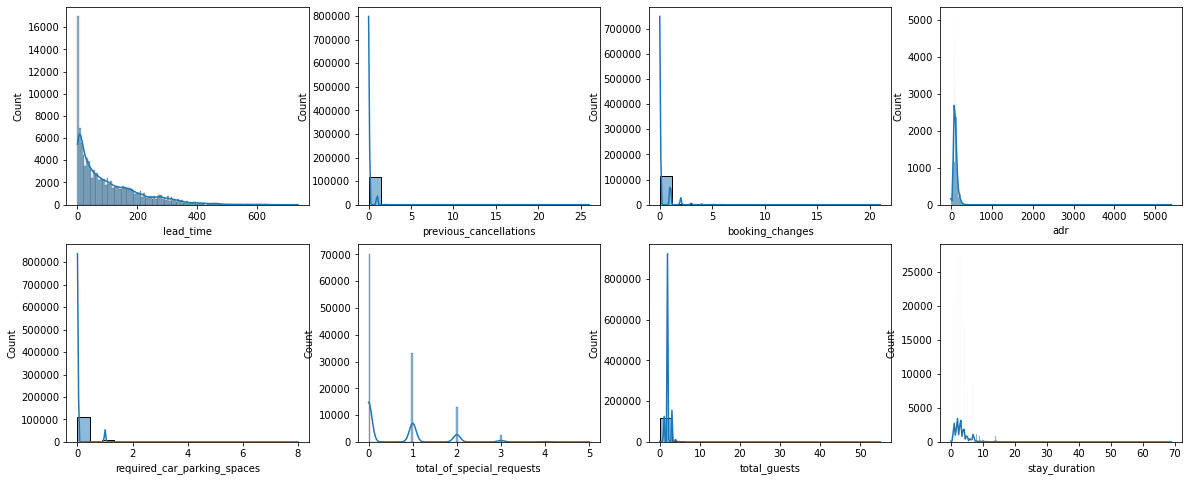

In [ ]:
plt.figure(figsize=(20,8))
for i in enumerate(numeric_var):
  plt.subplot(2,4,i[0]+1)
  sns.histplot(df[i[1]], kde=True);

Terlihat bahwa data tidak terdistribusi normal

Boxplot

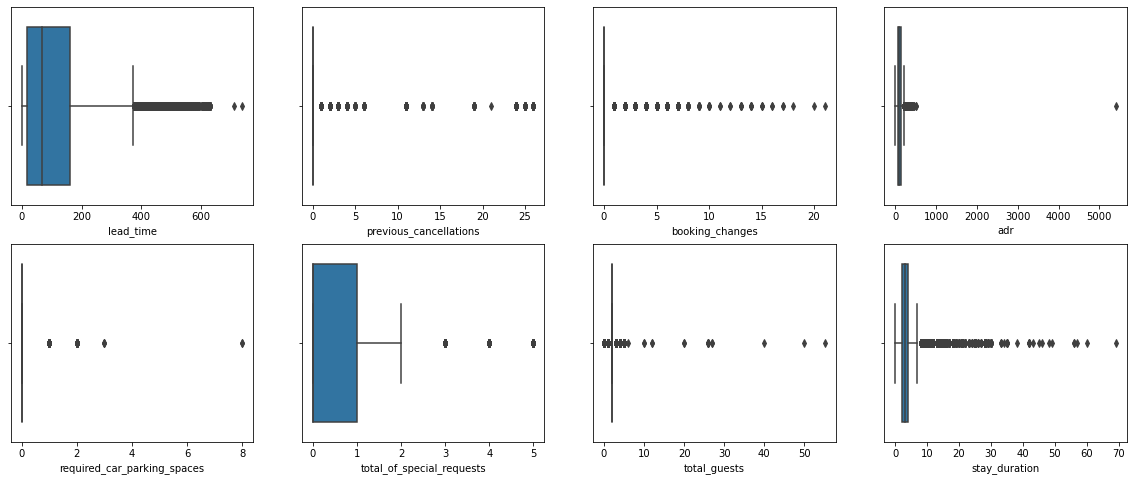

In [ ]:
plt.figure(figsize=(20,8))
for i in enumerate(numeric_var):
  plt.subplot(2,4,i[0]+1)
  sns.boxplot(x = df[i[1]]);

Dapat terlihat bahwa seluruh kolom memiliki distribusi skewed ke kanan. Terlihat dari box plot bahwa banyak outlier yang ada pada setiap kolom. Namun, kelompok kami akan membiarkannya karena kebanyakan dari outlier iniadalah local outlier, yang mungkin memang seperti itu datanya. Untuk global outlier pada kolom lead_time, adr, required car spaces, total special request, dan stay duration akan dilihat lebih jelas

Kolom Lead Time

Lead time adalah waktu interval dari booking dengan arrival, maka akan dievaluasi outlier yang ada

In [ ]:
df[df['lead_time'] > 250].sort_values(by='lead_time',ascending=False).head()

,hotel,is_canceled,lead_time,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_guests,stay_duration,Is_local
1,Resort Hotel,0,737,Direct,Direct,0,0,4,No Deposit,Transient,0.0,0,0,Check-Out,2.0,0,Local
4182,Resort Hotel,0,709,Direct,Direct,0,0,2,No Deposit,Transient,68.0,0,0,Check-Out,2.0,28,Not local
65237,City Hotel,1,629,Groups,TA/TO,0,0,0,Non Refund,Transient,62.0,0,0,Canceled,2.0,2,Local
65244,City Hotel,1,629,Groups,TA/TO,0,0,0,Non Refund,Transient,62.0,0,0,Canceled,2.0,2,Local
65254,City Hotel,1,629,Groups,TA/TO,0,0,0,Non Refund,Transient,62.0,0,0,Canceled,2.0,2,Local


Terlihat bahwa, banyak data yang memiliki lead time lebih dari 1 tahun. Outlier ini akan kami biarkan, dengan asumsi bahwa hotel memang memperbolehkan tamu memesan kamar dengan interval 1 tahun dari arrival date

Kolom adr

adr (Average Daily Rate) merupakan harga sewa rata rata per hari. Dihitung dengan membagi total biaya dengan lama stay

In [ ]:
df['adr'].max()

5400.0

Terlihat bahwa outlier bernilai sebesar 5400. Hal ini akan kami biarkan, karena kemungkinan guest ini menyewa kamar dengan rate tinggi untuk jangka waktu lama

Kolom car spaces

In [ ]:
df['required_car_parking_spaces'].mode()

0    0
dtype: int64

In [ ]:
df[df['required_car_parking_spaces']>0].count()

hotel                          7416
is_canceled                    7416
lead_time                      7416
market_segment                 7416
distribution_channel           7416
is_repeated_guest              7416
previous_cancellations         7416
booking_changes                7416
deposit_type                   7416
customer_type                  7416
adr                            7416
required_car_parking_spaces    7416
total_of_special_requests      7416
reservation_status             7416
total_guests                   7416
stay_duration                  7416
Is_local                       7416
dtype: int64

In [ ]:
df['required_car_parking_spaces'].max()

8

Dari sini terlihat bahwa, sebenarnya tidak banyak orang yang membutuhkan parkir, namun outlier menunjukkan angka 8. Hal ini juga akan dibiarkan, dikarenakan mungkin terdapat guest berupa company yang membawa grup banyak sehingga mobil mungkin lebih dari 5

Kolom total special requests

In [ ]:
df['required_car_parking_spaces'].max()

8

In [ ]:
df['required_car_parking_spaces'].mode()

0    0
dtype: int64

Kolom special request menunjukkan banyaknya permintaan spesial dari pelanggan, seperti memesan makanan, memesan double bed, etc. Kolom ini juga dibiarkan

Kolom Stay Duration

In [ ]:
df['stay_duration'].max()

69

In [ ]:
df[df['stay_duration'] == 69]

,hotel,is_canceled,lead_time,market_segment,distribution_channel,is_repeated_guest,previous_cancellations,booking_changes,deposit_type,customer_type,adr,required_car_parking_spaces,total_of_special_requests,reservation_status,total_guests,stay_duration,Is_local
14038,Resort Hotel,0,126,Direct,Direct,0,0,2,No Deposit,Transient,110.0,0,3,Check-Out,1.0,69,Not local


Outlier menunjukkan kalau terdapat guest yang stay di hotel selama 69 hari. Dan dari data terlihat, bahwa guest hanya berjumlah satu orang. Setelah pertimbangan lebih lanjut, kami akan membiarkan outlier ini dikarenakan guest melakukan check out, sehingga data ini benar dan bukan merupakan data palsu

Data Correlation

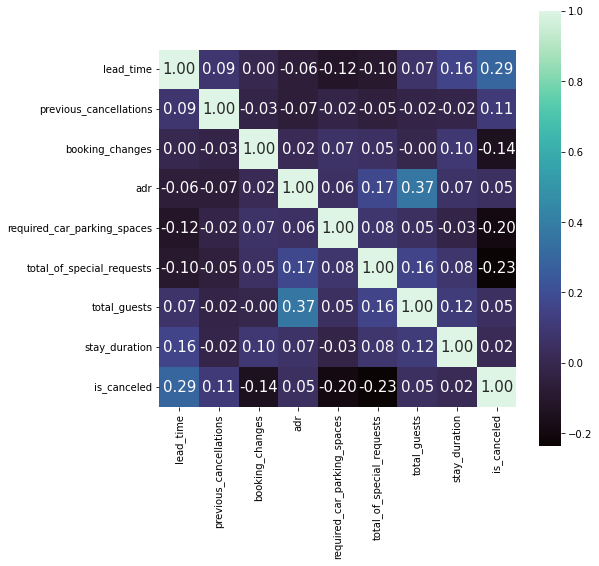

In [ ]:
plt.figure(figsize=(8,8))
sns.heatmap(df[['lead_time','previous_cancellations','booking_changes','adr','required_car_parking_spaces','total_of_special_requests','total_guests',
               'stay_duration','is_canceled']].corr(),
            cbar=True, annot=True, fmt='.2f', square=True, annot_kws={'size': 15}, cmap='mako');

Dari correlation matrix yang ada, dapat dilihat bahwa fitur paling tinggi korelasinya dengan cancelation rate adalah lead time. Namun tidak ada feature feature yang berkorelasi > 0.7 sehingga tidak ada multicolinearity/redundant

Pipeline

Di bawah ini kami menggunakan pipeline untuk mempermudah proses modelling

In [ ]:
nums1 = ['lead_time','previous_cancellations','booking_changes','adr','required_car_parking_spaces','total_of_special_requests','total_guests',
        'stay_duration']
scaler = StandardScaler()
power = PowerTransformer(method='yeo-johnson')
numeric_pipe = Pipeline([
   ('scaler', scaler),
   ('power', power)  
])

ordinal_cat = ['deposit_type','reservation_status','is_repeated_guest']
deposit_type_rank = ['No Deposit', 'Refundable','Non Refund']
reservation_status_rank = ['Canceled','No-Show','Check-Out']
is_repeated_guest_rank = [0, 1]
ordinalencoder = OrdinalEncoder(categories=[deposit_type_rank, reservation_status_rank, is_repeated_guest_rank])
ordinal_pipe = Pipeline([
        ('ordinalencoder', ordinalencoder)  
])

nominal_cat = ['customer_type','hotel','Is_local']#,'market_segment','distribution_channel']
onehotencoder = OneHotEncoder(handle_unknown='ignore', drop = 'first')
nominal_pipe = Pipeline([ 
    ('onehotencoder', onehotencoder)
])

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric_pipe', numeric_pipe, nums1),
    ('ordinal_pipe', ordinal_pipe, ordinal_cat),
    ('nominal_pipe', nominal_pipe, nominal_cat)
])

In [ ]:
#splitting data
X = df.drop(columns=['is_canceled'])
y = df['is_canceled']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((83573, 16), (35817, 16), (83573,), (35817,))

In [ ]:
#sampling
X_train = X_train.sample(frac = .55)
X_test = X_test.sample(frac = .55)
y_train = y_train.sample(frac = .55)
y_test =  y_test.sample(frac = .55)

In [ ]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((45965, 16), (19699, 16), (45965,), (19699,))

In [ ]:
#cross validation
models = [
    #['Logistic Regression', LogisticRegression()],
    ['KNN', KNeighborsClassifier()],
    ['Decision Tree', DecisionTreeClassifier(random_state=42)],
    ['Random Forest', RandomForestClassifier(random_state=42)]
]
def cross_validation(models):
    model_name = []

    cv_recall_mean = []
    cv_recall_std = []
    training_recall = []
    
    cv_precision_mean = []
    cv_precision_std = []
    training_precision = []
    
    cv_f1_mean = []
    cv_f1_std = []
    training_f1 = []
    
    cv_roc_auc_mean = []
    cv_roc_auc_std = []
    training_roc_auc = []

    for name, model in models:
    
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('model', model)
        ]) 
        model_name.append(name)

        #scoring
        scoring= ['recall', 'precision', 'f1', 'roc_auc']
        
        #cross_validate 
        cv_score = cross_validate(pipeline, X_train, y_train, scoring=scoring, cv=10, n_jobs = -1,return_train_score=True)
        
        # training
        training_recall.append(abs(cv_score['train_recall']).mean())
        training_precision.append(abs(cv_score['train_precision']).mean())
        training_f1.append(abs(cv_score['train_f1']).mean())
        training_roc_auc.append(abs(cv_score['train_roc_auc']).mean())
        
        #tes                  
        cv_recall_mean.append(abs(cv_score['test_recall']).mean())
        cv_recall_std.append(abs(cv_score['test_recall']).std())
        cv_precision_mean.append(abs(cv_score['test_precision']).mean())
        cv_precision_std.append(abs(cv_score['test_precision']).std())
        cv_f1_mean.append(abs(cv_score['test_f1']).mean())
        cv_f1_std.append(abs(cv_score['test_f1']).std())
        cv_roc_auc_mean.append(abs(cv_score['test_roc_auc']).mean())
        cv_roc_auc_std.append(abs(cv_score['test_roc_auc']).std())
        

    return pd.DataFrame({
        'Model': model_name,
        'Training Recall' : training_recall,
        'CV Recall (mean)': cv_recall_mean,
        'CV Recall (std)': cv_recall_std,
        'Training Precision' : training_precision,
        'CV Precision (mean)' : cv_precision_mean,
        'CV Precision (std)' : cv_precision_std,
        'Training F1' : training_f1,
        'CV F1 (mean)' : cv_f1_mean,
        'CV F1 (std)' : cv_f1_std,
        'Training AUC_ROC' : training_roc_auc,
        'CV AUC_ROC (mean)' : cv_roc_auc_mean,
        'CV AUC_ROC (std)' : cv_roc_auc_std,
    })

In [ ]:
cv_result = cross_validation(models)

In [ ]:
cv_result

,Model,Training Recall,CV Recall (mean),CV Recall (std),Training Precision,CV Precision (mean),CV Precision (std),Training F1,CV F1 (mean),CV F1 (std),Training AUC_ROC,CV AUC_ROC (mean),CV AUC_ROC (std)
0,KNN,0.453118,0.266081,0.010789,0.634167,0.370347,0.009968,0.528552,0.309626,0.010336,0.735638,0.501953,0.007307
1,Decision Tree,0.793887,0.326748,0.011283,0.958066,0.372582,0.010505,0.868281,0.348090,0.009837,0.979703,0.503597,0.010295
2,Random Forest,0.824539,0.223277,0.009677,0.926482,0.370840,0.009809,0.872539,0.278655,0.009499,0.975351,0.503658,0.007513


Hyperparameter Tuning

In [ ]:
#Hyperparameter Tuning (Randomizer)
#Hyptun Logistic Regression

randomforest = RandomForestClassifier()

pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('algo', randomforest)
    ])

param = {'algo__n_estimators': [100, 150, 200],
 'algo__max_depth': [20, 50, 80],
 'algo__max_features': [0.3, 0.6, 0.8],
 'algo__min_samples_leaf': [1, 5, 10]}


rs_rf = RandomizedSearchCV(estimator=pipeline, param_distributions=param, scoring='roc_auc', random_state=42, cv=10, n_jobs=-1, verbose=1)
rs_rf.fit(X_train, y_train)

print(rs_rf.best_params_)
print(rs_rf.score(X_train, y_train), rs_rf.best_score_)

Fitting 10 folds for each of 10 candidates, totalling 100 fits
{'algo__n_estimators': 150, 'algo__min_samples_leaf': 1, 'algo__max_features': 0.3, 'algo__max_depth': 50}
0.9742303272165563 0.5028389762740256


In [ ]:
randomforest = RandomForestClassifier(n_estimators = 100, min_samples_leaf= 1,max_features = 0.3,max_depth = 20)
model = Pipeline([
        ('preprocessor', preprocessor),
        ('algo', randomforest)
    ]).fit(X_train, y_train)

In [ ]:
y_pred = model.predict(X_test) 

In [ ]:
roc_auc_score(y_test,y_pred)

0.4975905819683903

              precision    recall  f1-score   support

           0       0.68      1.00      0.81     29004
           1       0.97      0.22      0.35     16961

    accuracy                           0.71     45965
   macro avg       0.83      0.61      0.58     45965
weighted avg       0.79      0.71      0.64     45965



Text(56.5, 0.5, 'Realita')

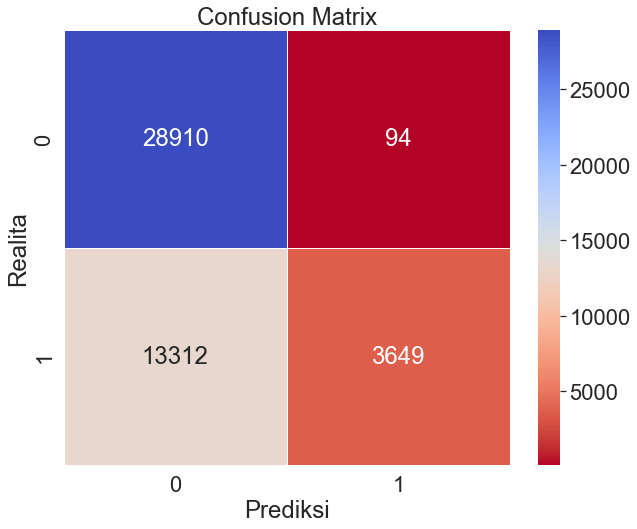

In [ ]:
#confusion pada data train logreg
plt.rcParams['figure.figsize'] = (10,8)
sns.set(font_scale=2)
cnf_matrix = metrics.confusion_matrix(y_train, model.predict(X_train))
print(metrics.classification_report(y_train, model.predict(X_train)))
sns.heatmap(cnf_matrix,cmap='coolwarm_r',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')

plt.xlabel('Prediksi')
plt.ylabel('Realita')

In [ ]:
asa = model[:-1].get_feature_names_out()
feat_importances = model.steps[1][1].feature_importances_

In [ ]:
# Zip coefficients and names together and make a DataFrame
zipped = zip(asa, feat_importances)
df_feat = pd.DataFrame(zipped, columns=["feature", "value"])
# Sort the features by the absolute value of their coefficient
df_feat["abs_value"] = df_feat["value"].apply(lambda x: abs(x))
df_feat["colors"] = df_feat["value"].apply(lambda x: "green" if x > 0 else "red")
df_feat = df_feat.sort_values("abs_value", ascending=False)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(12, 7))
sns.barplot(x="feature",
            y="value",
            data=df_feat.head(20),
           palette=df_feat.head(20)["colors"])
ax.set_xticklabels(ax.get_xticklabels(), rotation=90, fontsize=20)
ax.set_title("Top 20 Features", fontsize=25)
ax.set_ylabel("Coef", fontsize=22)
ax.set_xlabel("Feature Name", fontsize=22)

In [ ]:
hasil_prediksi = model.predict(X_test)
pred1 = hasil_prediksi[0]

In [ ]:
pred2 = hasil_prediksi[1]

In [ ]:
pred3 = hasil_prediksi[5]

In [ ]:
y_test

38943     0
30587     0
114396    0
104104    0
54600     1
         ..
89446     0
78302     0
31997     0
65473     1
6362      1
Name: is_canceled, Length: 19699, dtype: int64

In [ ]:
print('Pelanggan aslinya : ', y_test[38943])
print('Pelanggan diprediksi : ',pred1)

Pelanggan aslinya :  0
Pelanggan diprediksi :  0


In [ ]:
print('Pelanggan aslinya : ', y_test[30587])
print('Pelanggan diprediksi : ',pred2)

Pelanggan aslinya :  0
Pelanggan diprediksi :  0


In [ ]:
print('Pelanggan aslinya : ', y_test[54600])
print('Pelanggan diprediksi : ',pred3)

Pelanggan aslinya :  1
Pelanggan diprediksi :  0
